### 2 Predicting Yelp Ratings

In [1]:
import numpy as np
import pandas as pd

In [2]:
yelp_train = pd.read_csv("/Users/yixuanwang/Desktop/ucb_21/IEOR_142/hw3/yelp142_train.csv")
yelp_test = pd.read_csv("/Users/yixuanwang/Desktop/ucb_21/IEOR_142/hw3/yelp142_test.csv")
yelp_train.info()
yelp_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6272 entries, 0 to 6271
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   stars                       6272 non-null   float64
 1   review_count                6272 non-null   int64  
 2   GoodForKids                 6272 non-null   object 
 3   Alcohol                     6272 non-null   object 
 4   BusinessAcceptsCreditCards  6272 non-null   object 
 5   WiFi                        6272 non-null   object 
 6   BikeParking                 6272 non-null   object 
 7   ByAppointmentOnly           6272 non-null   object 
 8   WheelechairAccessible       6272 non-null   object 
 9   OutdoorSeating              6272 non-null   object 
 10  RestaurantsReservations     6272 non-null   object 
 11  DogsAllowed                 6272 non-null   object 
 12  Caters                      6272 non-null   object 
dtypes: float64(1), int64(1), object(1

,stars,review_count,GoodForKids,Alcohol,BusinessAcceptsCreditCards,WiFi,BikeParking,ByAppointmentOnly,WheelechairAccessible,OutdoorSeating,RestaurantsReservations,DogsAllowed,Caters
0,3.5,26,(Missing),(Missing),TRUE,(Missing),TRUE,(Missing),(Missing),(Missing),(Missing),(Missing),(Missing)
1,3.0,40,TRUE,'full_bar',TRUE,'free',FALSE,(Missing),(Missing),TRUE,FALSE,(Missing),(Missing)
2,4.5,45,TRUE,'full_bar',TRUE,'free',FALSE,(Missing),(Missing),TRUE,FALSE,(Missing),(Missing)
3,4.5,61,TRUE,(Missing),TRUE,(Missing),(Missing),(Missing),(Missing),FALSE,(Missing),(Missing),FALSE
4,3.5,5,TRUE,'beer_and_wine',TRUE,(Missing),(Missing),(Missing),(Missing),FALSE,FALSE,(Missing),(Missing)



### a) (5 points) There are many missing entries in this dataset, denoted by (Missing) in the data files. In particular, all of the attribute features contain missing values and Table 1 reports the percentage of observations where each attribute is missing. In general, there are several approaches for dealing with missing values in supervised learning. Note that each attribute with missing values in our dataset is a categorical feature and, in the subsequent models that you will build, you should treat (Missing) as an explicit category. Do you think this modeling choice is reasonable or not? Explain your answer.

Yes, it is reasonable, because the missing data can be interpreted as a special group, where no information is available. For any categorical variable, this “(Missing)” category means that the owner did not provide any information for this variable. But the act of not providing information itself may be a signal of the quality of the restaurant. This approach is also quite flexible as compared to throwing away rows, for example, since it allows us to use partial information available for each restaurant.


### b) (15 points) Let us start by building regression models for predicting stars based on all of the provided features listed in Table 1. All of your models should, of course, be built only using the training data provided in the yelp142 train.csv file


**i) First build a linear regression model.**

In [3]:
import statsmodels.formula.api as smf

ols = smf.ols(formula='stars ~ review_count + C(GoodForKids, Treatment(reference="(Missing)")) + C(Alcohol, Treatment(reference="(Missing)")) + C(BusinessAcceptsCreditCards, Treatment(reference="(Missing)")) + C(WiFi, Treatment(reference="(Missing)")) + C(BikeParking, Treatment(reference="(Missing)")) + C(ByAppointmentOnly, Treatment(reference="(Missing)")) + C(WheelechairAccessible, Treatment(reference="(Missing)")) + C(OutdoorSeating, Treatment(reference="(Missing)")) + C(RestaurantsReservations, Treatment(reference="(Missing)")) + C(DogsAllowed, Treatment(reference="(Missing)")) + C(Caters, Treatment(reference="(Missing)"))', 
                 data=yelp_train)
model1 =ols.fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     47.80
Date:                Thu, 22 Apr 2021   Prob (F-statistic):          3.10e-215
Time:                        18:31:25   Log-Likelihood:                -7317.5
No. Observations:                6272   AIC:                         1.469e+04
Df Residuals:                    6246   BIC:                         1.486e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

**ii) Now build a regression tree model (using an implementation of the CART algorithm). Select the complexity parameter (i.e., ccp alpha in sklearn) value for the tree through cross-validation, and explain how you did the cross-validation and how you selected the complexity parameter value.**


In [4]:
from sklearn.model_selection import train_test_split

y = yelp_train['stars']
X = pd.get_dummies(yelp_train.drop(['stars'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)
X_train.shape, X_test.shape

((4390, 36), (1882, 36))

(ii) Referring to the code below, to do the cross-validation, we need to:
1. specify a grid with different values of ccp alpha,
2. initialize a DecisionTreeRegressor,
3. use the KFold function to make sure that the data is randomly split into k-folds. “n splits” is usually set as 5, but it can be any value between 5 and 10; “random state” needs to be specified, although it can be any value; “shuffle” has to be True
4. correctly specify the parameters of GridSearchCV, where scoring = ’r2’ or ’rmse’ and cv =cv.
5. We choose the best value of ‘ccp alpha’, by looking at the best params attribute, which is the one that corresponds to the highest validation scoring.

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

grid_values_regression_tree = {'ccp_alpha': np.linspace(0, 0.001, 51)} # set 0.001 as the step size

dtr_regression_tree = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=20, random_state=88)

cv_regression_tree = KFold(n_splits=5,random_state=1,shuffle=True) 

dtr_cv_regression_tree = GridSearchCV(dtr_regression_tree, param_grid=grid_values_regression_tree, scoring='r2', cv=cv_regression_tree, verbose=0)

dtr_cv_regression_tree.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=DecisionTreeRegressor(min_samples_leaf=5,
                                             min_samples_split=20,
                                             random_state=88),
             param_grid={'ccp_alpha': array([0.0e+00, 2.0e-05, 4.0e-05, 6.0e-05, 8.0e-05, 1.0e-04, 1.2e-04,
       1.4e-04, 1.6e-04, 1.8e-04, 2.0e-04, 2.2e-04, 2.4e-04, 2.6e-04,
       2.8e-04, 3.0e-04, 3.2e-04, 3.4e-04, 3.6e-04, 3.8e-04, 4.0e-04,
       4.2e-04, 4.4e-04, 4.6e-04, 4.8e-04, 5.0e-04, 5.2e-04, 5.4e-04,
       5.6e-04, 5.8e-04, 6.0e-04, 6.2e-04, 6.4e-04, 6.6e-04, 6.8e-04,
       7.0e-04, 7.2e-04, 7.4e-04, 7.6e-04, 7.8e-04, 8.0e-04, 8.2e-04,
       8.4e-04, 8.6e-04, 8.8e-04, 9.0e-04, 9.2e-04, 9.4e-04, 9.6e-04,
       9.8e-04, 1.0e-03])},
             scoring='r2')

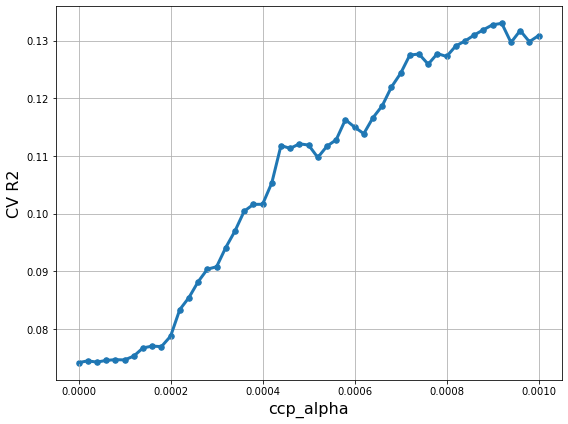

In [6]:
import matplotlib.pyplot as plt

ccp_alpha = dtr_cv_regression_tree.cv_results_['param_ccp_alpha'].data
R2_scores = dtr_cv_regression_tree.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('ccp_alpha', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(ccp_alpha, R2_scores, s=30)
plt.plot(ccp_alpha, R2_scores, linewidth=3)
plt.grid(True, which='both')

plt.tight_layout()
plt.show()

In [7]:
# Find the best ccp_alpha by searching for which ccp_alpha brings the max CV R2
print('Best ccp_alpha', dtr_cv_regression_tree.best_params_)

Best ccp_alpha {'ccp_alpha': 0.00092}


**iii) Using the test set data provided in the yelp142 test.csv file, compute the OSR2 values of your linear regression and regression tree models. Also, compute the MAE (mean absolute error) values of both models. How do you judge the performance of the two models?**

The OSR2 is 0.180 and 0.178 for the OLS and the regression tree model; the MAE is 0.617 and 0.612 respectively. Overall, the performance of these two models are not satisfactory.

In [8]:
# Regression tree
def OSR2_1(model, X_test, y_test, y_train):
    global y_pred_tree
    y_pred_tree = model.predict(X_test)
    SSE = np.sum((y_test - y_pred_tree)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)
OSR2_1(dtr_cv_regression_tree, X_test, y_test, y_train)

0.12520320053344702

In [9]:
# Regression tree MAE
from sklearn.metrics import mean_absolute_error

MAE_regression_tree = mean_absolute_error(y_test, dtr_cv_regression_tree.predict(X_test))
MAE_regression_tree

0.6131418824050957

In [10]:
# Linear R2
def OSR2_linear_reg(model, df_train, df_test, dependent_var):   
    y_test = df_test[dependent_var]
    y_pred = model.predict(df_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(df_train[dependent_var]))**2)    
    return 1 - SSE/SST

OSR2_linear_reg(model1, yelp_train, yelp_test, 'stars' )

0.18041519241200354

In [11]:
# Linear Reg MAE
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
MAE_linear_reg = mean_absolute_error(y_test, y_pred)
MAE_linear_reg

0.6195764795429983

**c) (5 points) Regression may not be the most appropriate modeling technique for this data. In particular, it is plausible that restaurants may be mostly concerned with ensuring that their star rating is high enough and not particularly concerned with precisely predicting the value of this rating. Therefore, let us instead consider a classification problem where the goal is to predict if the star rating is greater than or equal to 4 or not.
i) Construct a new variable in your training and test datasets called fourOrAbove. This variable should be equal to 1 if stars is greater than or equal to 4 and equal to 0 otherwise.**

In [12]:
#linear regression

fourOrAbove_train = [1 if i>= 4.0 else 0 for i in yelp_train['stars']]
fourOrAbove_test = [1 if i>= 4.0 else 0 for i in yelp_test['stars']]
yelp_4_train = yelp_train.copy(deep = True)
yelp_4_test = yelp_test.copy(deep = True)
yelp_4_train['fourOrAbove'] = fourOrAbove_train
yelp_4_test['fourOrAbove'] = fourOrAbove_test
yelp_4_train.drop(['stars'], axis = 1, inplace = True)
yelp_4_test.drop(['stars'], axis = 1, inplace = True)

In [13]:
yelp_4_train.head()


,review_count,GoodForKids,Alcohol,BusinessAcceptsCreditCards,WiFi,BikeParking,ByAppointmentOnly,WheelechairAccessible,OutdoorSeating,RestaurantsReservations,DogsAllowed,Caters,fourOrAbove
0,26,(Missing),(Missing),TRUE,(Missing),TRUE,(Missing),(Missing),(Missing),(Missing),(Missing),(Missing),0
1,40,TRUE,'full_bar',TRUE,'free',FALSE,(Missing),(Missing),TRUE,FALSE,(Missing),(Missing),0
2,45,TRUE,'full_bar',TRUE,'free',FALSE,(Missing),(Missing),TRUE,FALSE,(Missing),(Missing),1
3,61,TRUE,(Missing),TRUE,(Missing),(Missing),(Missing),(Missing),FALSE,(Missing),(Missing),FALSE,1
4,5,TRUE,'beer_and_wine',TRUE,(Missing),(Missing),(Missing),(Missing),FALSE,FALSE,(Missing),(Missing),0


In [14]:
yelp_4_test.head()

,review_count,GoodForKids,Alcohol,BusinessAcceptsCreditCards,WiFi,BikeParking,ByAppointmentOnly,WheelechairAccessible,OutdoorSeating,RestaurantsReservations,DogsAllowed,Caters,fourOrAbove
0,11,(Missing),(Missing),TRUE,(Missing),(Missing),(Missing),(Missing),(Missing),FALSE,(Missing),(Missing),1
1,82,TRUE,'none',TRUE,'no',TRUE,(Missing),TRUE,FALSE,FALSE,(Missing),TRUE,1
2,3,(Missing),(Missing),TRUE,'no',TRUE,TRUE,TRUE,(Missing),(Missing),FALSE,(Missing),1
3,141,TRUE,'none',TRUE,'no',FALSE,(Missing),TRUE,FALSE,FALSE,(Missing),TRUE,1
4,222,TRUE,'none',TRUE,'free',TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,1



**d) Let us now work on building classification models for predicting fourOrAbove based on all of the provided features listed in Table 1. All of your models should, of course, be built only using the training data provided in the yelp142 train.csv file.**

**i) In this problem, we will weigh false positives and false negatives equally and therefore focus on accuracy (equivalently, error rate) as the primary performance metric. Do you think this modeling choice is reasonable or not? Explain your answer.**


Answer: No, because different weight of FP and FN values have different impact on our prediction. When it comes to profit, if we equal weights on both FP and FN value, we could not penalize and boost the loss function towards the preferred class, thus we are not evaluating our model in a systemetic way.**

**ii) A simple approach here is to use the previously built linear regression and regression tree models to address the classification task by thresholding their predictions at the value of 4. Write code for implementing this thresholding procedure for converting the predictions of your previously built regression models to predictions of fourOrAbove.**

In [15]:
# Linear d2

#linear_reg = {'star_predict_linear': y_pred}
#linear_reg = pd.DataFrame(data = linear_reg)
#linear_reg['fourOrAbove'] = np.where(linear_reg['star_predict_linear'] >= 4,1,0)
#linear_reg.head(5)


In [16]:
y_pred_ols = model1.predict(yelp_test.drop(['stars'], axis = 1))
y_pred_ols_threshold = [1 if i >= 4.0 else 0 for i in y_pred_ols]

y_pred_tree = dtr_cv_regression_tree.predict(X_test)
y_pred_tree_threshold = [1 if i >= 4.0 else 0 for i in y_pred_tree]


**iii) Now build a logistic regression model. Remember to use all of the provided independent variables, and you do not have to do variable selection in this problem. Please again use (Missing) as the reference level to be incorporated into the intercept term.**

In [17]:
d3_logistic_regression_model = smf.logit(formula = 'fourOrAbove~ review_count + C(GoodForKids, Treatment(reference="(Missing)")) + C(Alcohol, Treatment(reference="(Missing)")) + C(BusinessAcceptsCreditCards, Treatment(reference="(Missing)")) + C(WiFi, Treatment(reference="(Missing)")) + C(BikeParking, Treatment(reference="(Missing)")) + C(ByAppointmentOnly, Treatment(reference="(Missing)")) + C(WheelechairAccessible, Treatment(reference="(Missing)")) + C(OutdoorSeating, Treatment(reference="(Missing)")) + C(RestaurantsReservations, Treatment(reference="(Missing)")) + C(DogsAllowed, Treatment(reference="(Missing)")) + C(Caters, Treatment(reference="(Missing)"))',
                                                   data = yelp_4_train).fit()

print(d3_logistic_regression_model.summary())

Optimization terminated successfully.
         Current function value: 0.608938
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            fourOrAbove   No. Observations:                 6272
Model:                          Logit   Df Residuals:                     6246
Method:                           MLE   Df Model:                           25
Date:                Thu, 22 Apr 2021   Pseudo R-squ.:                  0.1113
Time:                        18:31:31   Log-Likelihood:                -3819.3
converged:                       True   LL-Null:                       -4297.5
Covariance Type:            nonrobust   LLR p-value:                9.494e-186
                                                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------

**iv) Now build a classification tree model (using an implementation of the CART algorithm). Select the complexity parameter (i.e., ccp alpha in sklearn) value for the tree through cross-validation, and explain how you did the cross-validation and how you selected the complexity parameter value.**

In [18]:
yelp_train_d4 = pd.get_dummies(yelp_4_train, columns = ['GoodForKids', 'Alcohol', 'BusinessAcceptsCreditCards', 'WiFi',
                                                      'BikeParking', 'ByAppointmentOnly', 'WheelechairAccessible', 'OutdoorSeating',
                                                      'RestaurantsReservations', 'DogsAllowed', 'Caters'])

yelp_test_d4 = pd.get_dummies(yelp_4_test, columns = ['GoodForKids', 'Alcohol', 'BusinessAcceptsCreditCards', 'WiFi',
                                                      'BikeParking', 'ByAppointmentOnly', 'WheelechairAccessible', 'OutdoorSeating',
                                                      'RestaurantsReservations', 'DogsAllowed', 'Caters'])


In [19]:
x_train_d4 =pd.get_dummies(yelp_4_train.drop(['fourOrAbove'], axis = 1))
x_test_d4 =pd.get_dummies(yelp_4_test.drop(['fourOrAbove'], axis = 1))
y_train_d4 = yelp_4_train['fourOrAbove']
y_test_d4 = yelp_4_test['fourOrAbove']


In [20]:

x_train_d4.shape


(6272, 36)

In [21]:
x_test_d4.shape

(2688, 36)

In [22]:
x_train_d4.head(5)

,review_count,GoodForKids_(Missing),GoodForKids_FALSE,GoodForKids_TRUE,Alcohol_'beer_and_wine',Alcohol_'full_bar',Alcohol_'none',Alcohol_(Missing),BusinessAcceptsCreditCards_(Missing),BusinessAcceptsCreditCards_FALSE,...,OutdoorSeating_TRUE,RestaurantsReservations_(Missing),RestaurantsReservations_FALSE,RestaurantsReservations_TRUE,DogsAllowed_(Missing),DogsAllowed_FALSE,DogsAllowed_TRUE,Caters_(Missing),Caters_FALSE,Caters_TRUE
0,26,1,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
1,40,0,0,1,0,1,0,0,0,0,...,1,0,1,0,1,0,0,1,0,0
2,45,0,0,1,0,1,0,0,0,0,...,1,0,1,0,1,0,0,1,0,0
3,61,0,0,1,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
4,5,0,0,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(min_samples_leaf=5, 
                             ccp_alpha=0.003,
                             random_state = 88)

dtc = dtc.fit(x_train_d4, y_train_d4)

Node count = 9


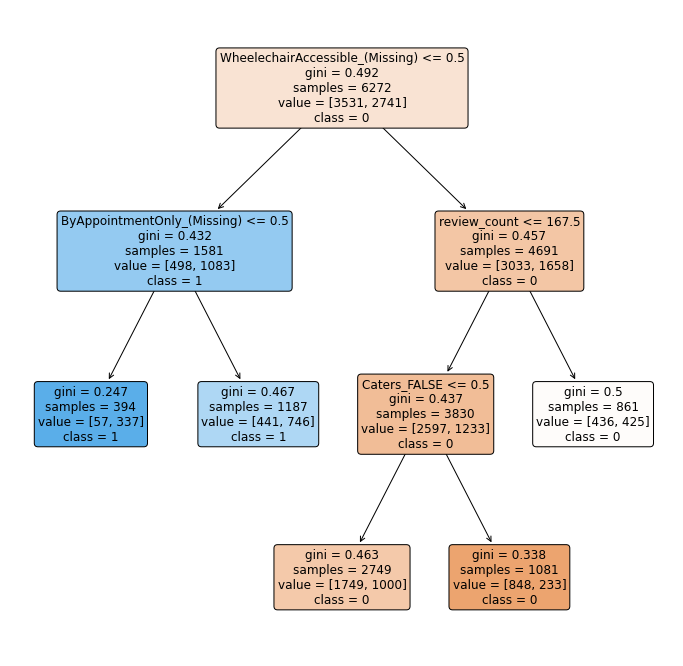

In [24]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

print('Node count =', dtc.tree_.node_count)
plt.figure(figsize=(12,12))
plot_tree(dtc, 
          feature_names=X_train.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12) 
plt.show()

**iv)explain how you did the cross-validation and how you selected the complexity parameter value.**

Answer: 
We first do the data cleaning part, drop unecessary columns and keep all necessary 36 columns to predict fourOrAbove. 
In order to select the best ccp_alpha, I tried a few different values. When ccp_alpha = 0.01 there are only 3 nodes and all 3 nodes are biased toward 0. When ccp_alpha = 0.0001, there are 1035 tree nodes which means we are overfitting the model. Then I have a ideal range where alpha should between 0.01 and 0.0001. I tried ccp_alpha = 0.005 and ccp_alpha = 0.003. It turns out that 0.003 is better than 0.005 where we make sure the model is not overfitting while less-biased at the same time.

**v)Now build a model using “vanilla” bagging of CART models. This can be achieved, for example, by setting m (i.e., max features in sklearn) equal to the total number of features when training a Random Forest model.**

- Vanilla Bagging

In [26]:
from sklearn.model_selection import train_test_split

y = yelp_4_train['fourOrAbove']
X = pd.get_dummies(yelp_4_train.drop(['fourOrAbove'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)
X_train.shape, X_test.shape

((4390, 36), (1882, 36))

In [27]:
len(yelp_train.columns)

13

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_vanilla = RandomForestClassifier(n_estimators = 500, min_samples_leaf=5, max_features=14, 
                                    random_state=88, verbose=1)
rf_vanilla.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.4s finished


RandomForestClassifier(max_features=14, min_samples_leaf=5, n_estimators=500,
                       random_state=88, verbose=1)

**vi) Now build a Random Forest model, and this time use cross-validation to select the m value for the Random Forests method. Explain how you did the cross validation and how you selected the value of m.**

In [29]:
from sklearn.ensemble import RandomForestClassifier
import time

grid_values = {'max_features': np.linspace(1,18,18, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]} 

tic = time.time()

random_forest = RandomForestClassifier() 

cv = KFold(n_splits=5,random_state=333,shuffle=True) 
rf_cv = GridSearchCV(random_forest, param_grid=grid_values, scoring='r2', cv=cv,verbose=2)
rf_cv.fit(X_train, y_train)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88, total=   1.0s
[CV] max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88, total=   1.1s
[CV] max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88, total=   0.9s
[CV] max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88, total=   1.0s
[CV] max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88, total=   1.0s
[CV] max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88, total=   1.3s
[CV] max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88 
[CV]  max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88, total=   1.3s
[CV] max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  2.9min finished


time: 173.62 s


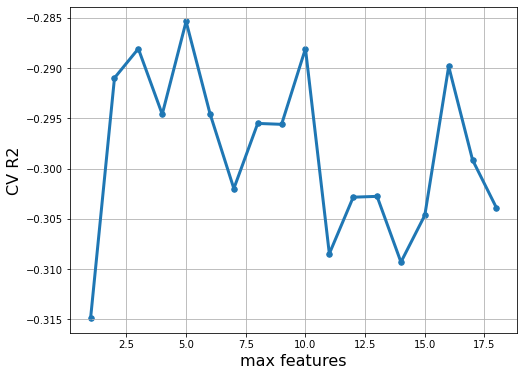

In [30]:
max_features = rf_cv.cv_results_['param_max_features'].data
R2_scores = rf_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(max_features, R2_scores, s=30)
plt.plot(max_features, R2_scores, linewidth=3)
plt.grid(True, which='both')

In [31]:
print(rf_cv.best_params_)

{'max_features': 5, 'min_samples_leaf': 5, 'n_estimators': 500, 'random_state': 88}


In [32]:
def OSR2(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

In [33]:
OSR2(rf_cv, X_test, y_test, y_train) #?

-0.3477755706152186

In [34]:
pd.DataFrame({'Feature' : X_train.columns,  
              'Importance score': 100*rf_cv.best_estimator_.feature_importances_}).round(1)


,Feature,Importance score
0,review_count,20.3
1,GoodForKids_(Missing),1.4
2,GoodForKids_FALSE,1.0
3,GoodForKids_TRUE,2.1
4,Alcohol_'beer_and_wine',1.1
5,Alcohol_'full_bar',1.9
6,Alcohol_'none',2.2
7,Alcohol_(Missing),1.0
8,BusinessAcceptsCreditCards_(Missing),0.3
9,BusinessAcceptsCreditCards_FALSE,1.1


#### Explain how you did the cross validation and how you selected the value of m.

Answer: All we did here is trying to prevent overfitting using corss valiadaiton and restrict the features that we have selected. In order to achieve cross validation to minimize bias, we 1) shuffle the dataset (using shuffle=True in Python), 2)split the data set into 5 groups (as we discussed in class 5-fold or 10-fold is the best), 3) we take out one group as hold out group/test set, fit the model on the remaining dataset and evaluate it on the test set. We do it for 5 times to get the most un-biased result we can get using the 5-fold cv random forest model.

I chose k = 5 instead of 1 or 2 as to minimize the difference in size between the training set and the resampling subsets. In other words, according to what we discusses in class, k = 5 would yield the optimized and un-biased result in a timely-manner.

**vii) Produce a table for evaluating the performance of the models that you have built. The table should consider the following models: a baseline model that predicts the most frequent outcome for fourOrAbove, the two regression models with thresholding, and all of the classification models built in this part of the problem. Additionally, the table should report the following performance metrics: accuracy (our primary performance metric), TPR, and FPR. All of these performance metrics should be computed using the test set data provided in the yelp142 test.csv file. How do you judge the performance of the models? Do the results seem reasonable to you? Which model would you recommend for this problem and why?**

### Baseline model

In [36]:
# Baseline model
default_false = np.sum(yelp_4_test['fourOrAbove'] == 0)
default_true = np.sum(yelp_4_test['fourOrAbove'] == 1)

print(pd.Series({'0': default_false, '1': default_true}))

accuracy_baseline = default_false/(default_false + default_true) #Accuracy = (TP+TN)/(TP+TN+FP+FN)
print('Accuracy_Baseline: %s '%accuracy_baseline)


0    1475
1    1213
dtype: int64
Accuracy_Baseline: 0.5487351190476191 


In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix(yelp_4_test['fourOrAbove'],[0] * yelp_test.shape[0])

array([[1475,    0],
       [1213,    0]])

In [41]:

negative_baseline = np.sum(yelp_4_test['fourOrAbove'] == 0)
positive_baseline = np.sum(yelp_4_test['fourOrAbove'] == 1)
TPR = 0/negative_baseline #TP/TP+FN
FPR = 0/positive_baseline #FP/FP+TN

print('TPR_Baseline: %s '%TPR)
print('FPR_Baseline: %s '%FPR)


TPR_Baseline: 0.0 
FPR_Baseline: 0.0 


the classification tree model out- performs the regression tree model.

**e) (15 points) Suppose that you are a data scientist working for Yelp and you have been tasked with producing a “how to guide” for Las Vegas restaurants, which is supposed to include tips for actions restaurants may take to achieve a high star rating. Use the provided data to construct a list of three such tips. Each of your tips should be justified by the data, and each justification should be understandable by a restaurant owner who may not know much about machine learning. This question is purposefully open ended, and you may consider using modeling techniques and/or visualizations to come up with and justify your three tips.**

Node count = 13


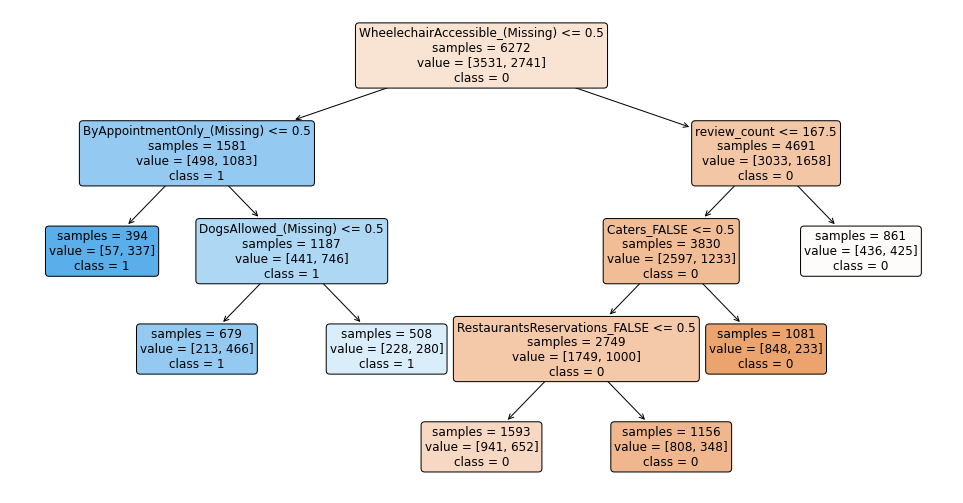

In [42]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

dtc_shallow = DecisionTreeClassifier(max_leaf_nodes = 7)
dtc_shallow.fit(x_train_d4, y_train_d4)

print('Node count =', dtc_shallow.tree_.node_count)
plt.figure(figsize = (17,9))
plot_tree(dtc_shallow, 
        feature_names =x_train_d4.columns,
        class_names = ['0','1'],
          filled = True,
          impurity = False,
          rounded = True,
          fontsize = 12)
plt.show()

From the plot above, we can observe that the first three splits that lead to Class = 1 are the blue nodes on the left. Furthermore, we can observe that WheelchairAccessible (Missing), ByAppoint- mentOnly (Missing), and DogsAllowed (Missing) are the decision nodes. A value of 0 (which is equivalent to <= 0.5), would lead to the left branch, which corresponds to class = 1. 

Therefore, we can conclude that the information of whether the restaurant is wheelchair accessible, whether it is by appointment only, and whether it allows dogs are important to achieving a high rating.